# Elite Prospect and Scraping

It's one of my project trying combining Webscrapping with Eliteprospects.

It will try to get information about past NHL Draft

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
def fetch_draft_data(year):
    # Fetch the webpage
    url = f'https://www.eliteprospects.com/draft/nhl-entry-draft/{year}'
    response = requests.get(url)
    html_content = response.text

    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the div with the ID 'drafted-players'
    div = soup.find('div', id='drafted-players')

    # If div is found, proceed to extract player data
    data = []
    if div:
        rows = div.find_all('tr')
        for row in rows:
            columns = row.find_all('td')
            # Extract text from each column
            row_data = [col.get_text(strip=True) for col in columns]
            # Prepend the year to each row's data
            row_data.insert(0, year)
            data.append(row_data)  # Append each row's data to the list
    else:
        print(f"Div with ID 'drafted-players' not found for year {year}.")
    
    return data

In [ ]:
# Define the years of interest
years = range(2007, 2023)

# Define custom headers
custom_headers = [
    "Year", "Pick", "", "Team", "Player", "Seasons", "GP", "Goals", "Assists", "Points", "PM"
]

# Initialize a list to hold all data
all_data = []

for year in years:
    year_data = fetch_draft_data(year)
    if year_data:
        all_data.extend(year_data)

In [13]:

# Create a DataFrame from the collected data
df = pd.DataFrame(all_data, columns=custom_headers)
print(df.head())

   Year     Pick                       Team                  Player Seasons  \
0  2007     None  None                 None                    None    None   
1  2007  ROUND 1  None                 None                    None    None   
2  2007       #1         Chicago Blackhawks        Patrick Kane (F)      18   
3  2007       #2        Philadelphia Flyers  James van Riemsdyk (F)      16   
4  2007       #3            Phoenix Coyotes         Kyle Turris (F)      14   

     GP Goals Assists Points    PM  
0  None  None    None   None  None  
1  None  None    None   None  None  
2  1230   471     813   1284   442  
3  1011   311     318    629   394  
4   776   168     256    424   343  


We can see from the page as well there it take some 'NaN value' for example for Round 1 that make the seperation between rounds.

We will drop those value.

In [6]:
# Drop rows where 'Team' or 'Player' is None or ""
df = df.dropna(subset=['Team', 'Player'])
df = df[(df['Team'] != "") & (df['Player'] != "")]

# Reset the index for cleanliness
df = df.reset_index(drop=True)

# Convert 'Points' column to numeric, coercing errors to NaN
df['Points'] = pd.to_numeric(df['Points'], errors='coerce')
df['Goals'] = pd.to_numeric(df['Goals'], errors='coerce')
df['Assists'] = pd.to_numeric(df['Assists'], errors='coerce')
df['GP'] = pd.to_numeric(df['GP'], errors='coerce')

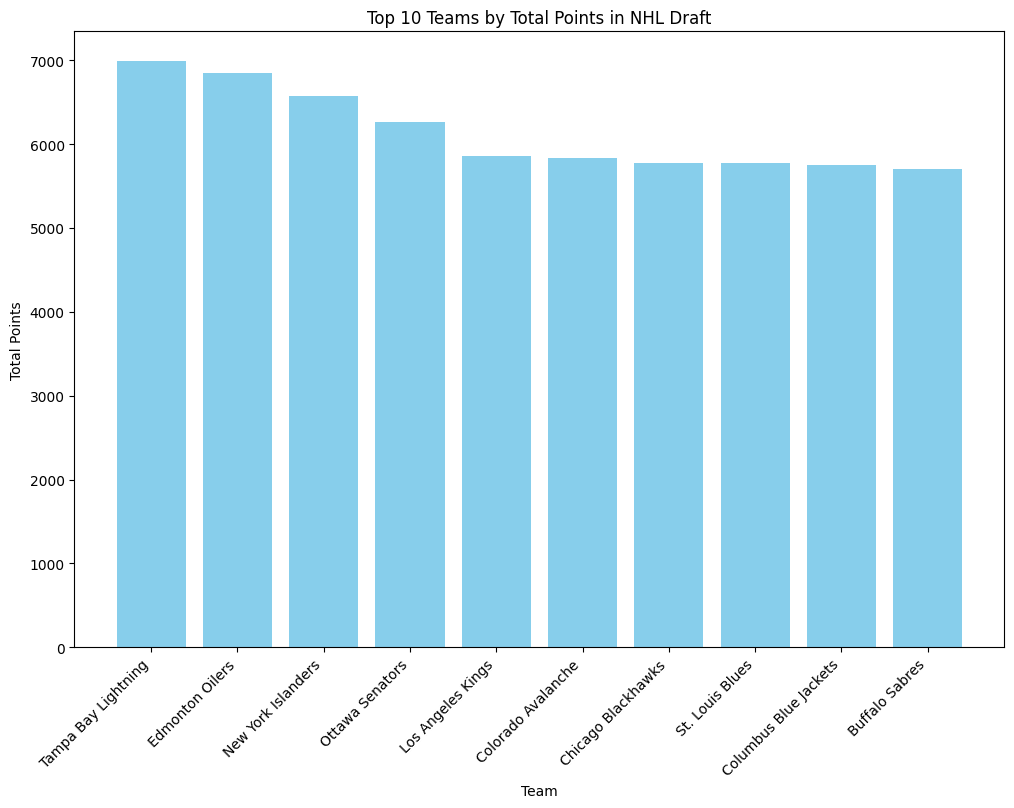

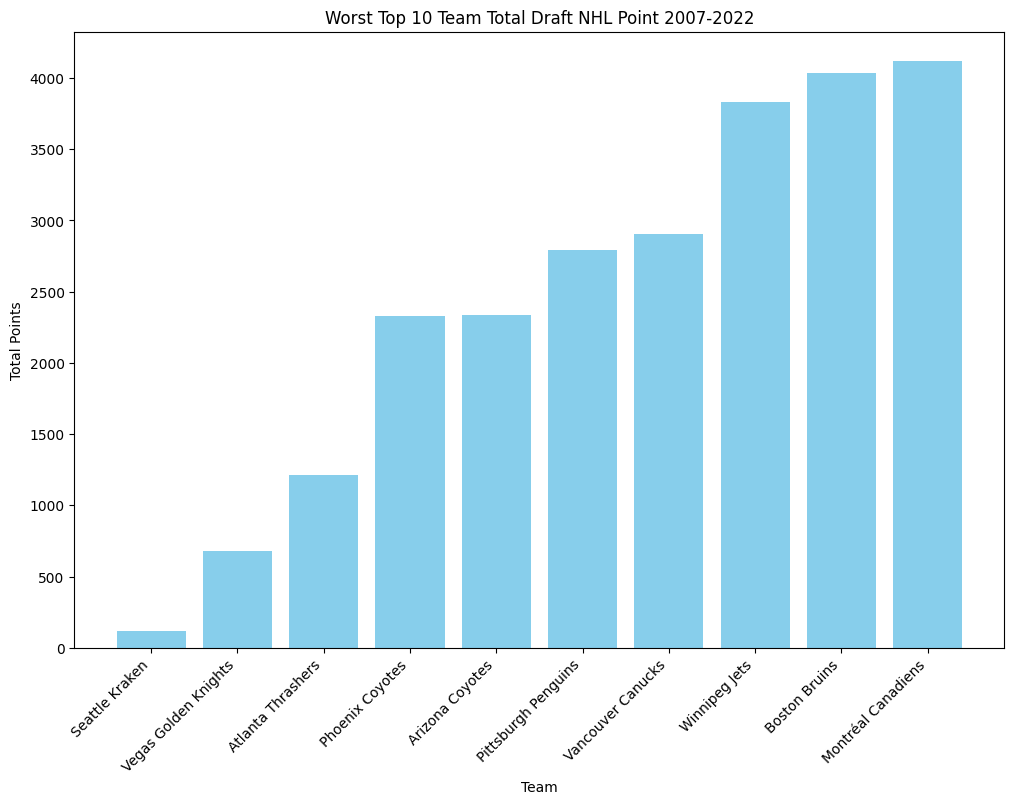

In [7]:
# Replace NaN values in 'Points' with 0
df['Points'] = df['Points'].fillna(0)
df['Goals'] = df['Goals'].fillna(0)
df['Assists'] = df['Assists'].fillna(0)
df['GP'] = df['GP'].fillna(0)

# Group by 'Team' and calculate the sum of 'Points'
points_per_team = df.groupby('Team')['Points'].sum().reset_index()

# Sort the teams by 'Points' in descending order and select the top 10
top_10_teams = points_per_team.nlargest(10, 'Points')

# Plot the top 10 teams using Matplotlib
plt.figure(figsize=(12, 8))
plt.bar(top_10_teams['Team'], top_10_teams['Points'], color='skyblue')
plt.xlabel('Team')
plt.ylabel('Total Points')
plt.title('Top 10 Teams by Total Points in NHL Draft')
plt.xticks(rotation=45, ha='right')
plt.show()

# Sort the teams by 'Points' in descending order and select the top 10
worst_10_teams = points_per_team.nsmallest(10, 'Points')

# Plot the top 10 teams using Matplotlib
plt.figure(figsize=(12, 8))
plt.bar(worst_10_teams['Team'], worst_10_teams['Points'], color='skyblue')
plt.xlabel('Team')
plt.ylabel('Total Points')
plt.title('Worst Top 10 Team Total Draft NHL Point 2007-2022')
plt.xticks(rotation=45, ha='right')
plt.show()
            

We can notice that our poor Penguins did not have great draft during this span. Even close to some teams that did not exist then or relocated since.

In [8]:
# Group by 'Team' and 'Pick' and calculate the sum of 'Points', 'Goals', and 'Assists'
points_per_team_pick = df.groupby(['Team', 'Pick'], as_index=False).agg({
    'Points': 'sum',
    'Goals': 'sum',
    'Assists': 'sum'
})

# For each team, find the pick with the maximum total points
best_selections = points_per_team_pick.loc[points_per_team_pick.groupby('Team')['Points'].idxmax()]

# Print the best selection for each team, including Goals and Assists
print(best_selections[['Team', 'Pick', 'Points', 'Goals', 'Assists']])
# Identify the pick position of interest from the best selections for Anaheim Ducks
anaheim_best_pick = best_selections[best_selections['Team'] == 'Anaheim Ducks']['Pick'].values[0]

# Filter the original DataFrame to get players drafted at that pick position for Anaheim Ducks
anaheim_players_at_pick = df[(df['Team'] == 'Anaheim Ducks') & (df['Pick'] == anaheim_best_pick)]

# Print the players drafted at the identified pick position for Anaheim Ducks
print(anaheim_players_at_pick[['Player', 'Pick','GP','Goals','Assists', 'Points']])

                       Team  Pick  Points  Goals  Assists
46            Anaheim Ducks   #26   785.0  317.0    468.0
139         Arizona Coyotes    #7   418.0  166.0    252.0
171       Atlanta Thrashers    #4   617.0  326.0    291.0
217           Boston Bruins    #2   788.0  351.0    437.0
300          Buffalo Sabres    #2  1052.0  466.0    586.0
410          Calgary Flames    #6  1117.0  462.0    655.0
492     Carolina Hurricanes    #5   843.0  280.0    563.0
515      Chicago Blackhawks    #1  1284.0  471.0    813.0
611      Colorado Avalanche    #1   899.0  335.0    564.0
765   Columbus Blue Jackets    #7   806.0  223.0    583.0
793            Dallas Stars  #129   924.0  390.0    534.0
886       Detroit Red Wings   #15   506.0  212.0    294.0
963         Edmonton Oilers    #1  2514.0  914.0   1600.0
1110       Florida Panthers    #3   853.0  259.0    594.0
1196      Los Angeles Kings    #2   757.0  184.0    573.0
1325         Minnesota Wild    #9   585.0  178.0    407.0
1382     Montr

We can see the best pick for each team. For example Anaheim's best pick is the #26 with 785 points. Furthermore, 
Kyle Palmieri and Shea Theodore are the two that contributed.

Now, we are searching for the best player that each team have picked.

In [9]:
# Group by 'Team', 'Player', and 'Pick' and calculate the sum of 'Points'
points_per_team_player = df.groupby(['Team', 'Player', 'Pick'])['Points'].sum().reset_index()

# For each team, find the player with the maximum total points
best_players = points_per_team_player.loc[points_per_team_player.groupby('Team')['Points'].idxmax()]

# Print the best player for each team along with their pick position without INDEX 
print(best_players.to_string(index=False))

                 Team                   Player Pick  Points
        Anaheim Ducks        Kyle Palmieri (F)  #26   479.0
      Arizona Coyotes       Clayton Keller (F)   #7   418.0
    Atlanta Thrashers         Evander Kane (F)   #4   617.0
        Boston Bruins         Tyler Seguin (F)   #2   788.0
       Buffalo Sabres         Sam Reinhart (F)   #2   538.0
       Calgary Flames      Johnny Gaudreau (F) #104   743.0
  Carolina Hurricanes         Jeff Skinner (F)   #7   670.0
   Chicago Blackhawks         Patrick Kane (F)   #1  1284.0
   Colorado Avalanche     Nathan MacKinnon (F)   #1   899.0
Columbus Blue Jackets        Jakub Voráček (F)   #7   806.0
         Dallas Stars           Jamie Benn (F) #129   907.0
    Detroit Red Wings         Dylan Larkin (F)  #15   506.0
      Edmonton Oilers       Connor McDavid (F)   #1   982.0
     Florida Panthers   Jonathan Huberdeau (F)   #3   720.0
    Los Angeles Kings         Drew Doughty (D)   #2   669.0
       Minnesota Wild      Mikael Granlu